# Google Colab Setup 

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

## Change path to directory of where notebook is located
%cd '/content/drive/MyDrive/Applied_NLP/HW3/hw3_code/'

## If no GPU selected it will ask for GPU to be selected
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


## This wraps output text according to the window size
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

Mounted at /content/drive/
/content/drive/MyDrive/Applied_NLP/HW3/hw3_code
Sat Mar 25 00:28:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
             

# Setup
This notebook is tested under [python 3. * . *]

## Library imports

In [ ]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import sys
import re
from copy import deepcopy
import pickle
import random
import seaborn as sns
import gensim
import torchtext
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch import optim
torch.manual_seed(10)
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# import gzip

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

print('Version information')

print('python: {}'.format(sys.version))
print('numpy: {}'.format(np.__version__))

Version information
python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
numpy: 1.22.4


# Load Dataset


We start by loading both data sets already split into an 80/20 train and test set.

In [ ]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

# Separate dataframes into train and test lists
x_train, y_train = list(df_train['headline']), list(df_train['label'])
x_test, y_test = list(df_test['headline']), list(df_test['label'])

Below is the number of headlines in the train and test set as well as a sample of the article headlines and its binary label, where 0 is considered not clickbait and 1 is clickbait.

In [ ]:
print(f'Number of Train Headlines: {len(x_train)}')
print(f'Number of Test Headlines: {len(x_test)}')

print('\n\nSample Label and Headlines:')
x = 105
for label, line in zip(y_train[x:x+5], x_train[x:x+5]):
    print(f'{label}: {line}')
    
print('\nOutput of Sample Headlines without Print Statement:')
x_train[x:x+5]

Number of Train Headlines: 19200
Number of Test Headlines: 4800


Sample Label and Headlines:
1: 27 Breathtaking Alternatives To A Traditional Wedding Bouquet <br>

1: 22 Pictures People Who Aren't Grad Students Will <strong>Never</strong> Understand

0: PepsiCo Profit Falls 43 Percent

0: Website of Bill O'Reilly, FOX News commentator, hacked in retribution

1: The Green Toy Soldiers From Your Childhood Now Come In Baller Yoga Poses A


Output of Sample Headlines without Print Statement:


['27 Breathtaking Alternatives To A Traditional Wedding Bouquet <br>\n',
 "22 Pictures People Who Aren't Grad Students Will <strong>Never</strong> Understand\n",
 'PepsiCo Profit Falls 43 Percent\n',
 "Website of Bill O'Reilly, FOX News commentator, hacked in retribution\n",
 'The Green Toy Soldiers From Your Childhood Now Come In Baller Yoga Poses A\n']

In [ ]:
df_train_wos = pd.read_csv('./data/train_wos.csv')
df_test_wos = pd.read_csv('./data/test_wos.csv')

# Separate dataframes into train and test lists
x_train_wos, y_train_wos = list(df_train_wos['article']), list(df_train_wos['label'])
x_test_wos, y_test_wos = list(df_test_wos['article']), list(df_test_wos['label'])

# Numerical label to domain mapping
wos_label = {0:'CS', 1:'ECE', 2:'Civil', 3:'Medical'}
# Numerical label to Numerical mapping
label_mapping = {0:0, 1:1, 4:2, 5:3}

for i, label in enumerate(y_train_wos):
    y_train_wos[i] = label_mapping[label]
for i, label in enumerate(y_test_wos):
    y_test_wos[i] = label_mapping[label]

In [ ]:

print(f'Number of Train Articles: {len(x_train_wos)}')
print(f'Number of Test Articles: {len(x_test_wos)}')

print('\nLabel Key:', wos_label)

print('\nSample Label and Articles:\n')
x = 107
for label, line in zip(y_train_wos[x:x+3], x_train_wos[x:x+3]):
    print(f'{label} - {wos_label[label]}: {line}')

Number of Train Articles: 1600
Number of Test Articles: 400

Label Key: {0: 'CS', 1: 'ECE', 2: 'Civil', 3: 'Medical'}

Sample Label and Articles:

0 - CS: An efficient procedure for calculating the electromagnetic fields in multilayered cylindrical structures is reported in this paper. Using symbolic computation, spectral Green's functions, suitable for numerical implementations are determined in compact and closed forms. Applications are presented for structures with two dielectric layers.

1 - ECE: A multifunctional platform based on the microhotplate was developed for applications including a Pirani vacuum gauge, temperature, and gas sensor. It consisted of a tungsten microhotplate and an on-chip operational amplifier. The platform was fabricated in a standard complementary metal oxide semiconductor (CMOS) process. A tungsten plug in standard CMOS process was specially designed as the serpentine resistor for the microhotplate, acting as both heater and thermister. With the sacrifici

## Section1: Word2Vec 

Word2vec is a method to efficiently create word embeddings. More details on word2vec and the intuition behind it can be found here :  
* [The Illustrated Word2vec by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/)

Word2vec is based on the idea that a word’s meaning is defined by its context. Context is represented as surrounding words. For the word2vec model, context is represented as N words before and N words after the current word. N is a hyperparameter. With larger N we can create better embeddings, but at the same time, such a model requires more computational resources. 

There are two word2vec architectures proposed in the paper:

* CBOW (Continuous Bag-of-Words) — a model that predicts a current word based on its context words.
* Skip-Gram — a model that predicts context words based on the current word.

We will be running our Word2Vec models on a very small dataset as described below.

In [ ]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',   
]

## Section 1.1: Implementing Continuous Bag-of-words From Scratch

A high level overview of the CBOW model can be described as :    
<p align="center"><img src="https://miro.medium.com/max/1400/1*ETcgajy5s0KNIfMgE5xOqg.png" width="75%" align="center"></p>

CBOW model takes several words, each goes through the same Embedding layer, and then word embedding vectors are averaged before going into the Linear layer.

We will be implementing this model using the architecture described below :    

<p align="center"><img src="https://miro.medium.com/max/1400/1*mLDM3PH12CjhaFoUm5QTow.png" width="75%" align="center"></p>

Here are the steps that needs to be followed for implementing CBOW model :    
* Step-1: Create vocabulary
  * Split each words into tokens.
  * Assign a unique ID to each unique token.

* Step-2: Create CBOW Embeddings
  * Create CBOW embeddings by taking context as N past words and N future words.

* Step-3: Implement CBOW Model
  * Implement CBOW model as described in the architecture above.
  
**Hint:** Since we are using the cross entropy loss, there is no need to apply the softmax after the linear layer.


## Section 1.1.1: Fetching CBOW embeddings


In [ ]:
from word2vec import Word2Vec

w2v = Word2Vec()
tokens = w2v.tokenize(corpus)
print ('tokens', tokens)
w2v.create_vocabulary(tokens)
source, target = w2v.cbow_embeddings(tokens)
# print ('source', source)
# print ('target', target)

tokens [['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['warsaw', 'is', 'poland', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital']]


## 1.1.2: Training CBOW model


In [ ]:

from word2vec import CBOW_Model

N_EPOCHS = 300
model = CBOW_Model(w2v.vocabulary_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()

for epoch in range(N_EPOCHS):
    total_loss = 0.0
    shuffled_i = list(range(0,len(target)))
    random.shuffle(shuffled_i)
    for i in shuffled_i:
        x = torch.from_numpy(np.asarray(source[i])).long().to(device)
        y = torch.from_numpy(np.asarray(target[i])).long().to(device)

        optimizer.zero_grad()
        outputs = model(x)
        print ('y', y)
        print ('outputs', outputs)
        loss = criterion(outputs, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
        
    if epoch % 20 == 0:    
      print("loss on epoch %i: %f" % (epoch, total_loss))

Streaming output truncated to the last 5000 lines.
outputs tensor([[-2.8482, -1.0704, -0.6456, -1.3812, -1.5330,  2.8801, -4.5718,  2.2576,
          2.2367, -1.1853, -1.4334,  2.2051,  2.8817, -1.1354,  2.2507]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y tensor([10], device='cuda:0')
outputs tensor([[-0.1272, -0.3412, -0.4423,  1.4031,  1.4975, -0.7374,  1.2307, -0.7437,
         -0.7374, -0.1307,  5.2409, -0.8031, -0.7458, -0.6708, -0.7510]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y tensor([12], device='cuda:0')
outputs tensor([[-2.8399, -1.0714, -0.6402, -1.3832, -1.5280,  2.8672, -4.5756,  2.2504,
          2.2343, -1.1771, -1.4283,  2.2074,  2.8758, -1.1305,  2.2444]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y tensor([5], device='cuda:0')
outputs tensor([[-2.8382, -1.0756, -0.6398, -1.3906, -1.5315,  2.8652, -4.5827,  2.2498,
          2.2356, -1.1766, -1.4292,  2.2110,  2.8808, -1.1314,  2.2443]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y 

## 1.1.3: Visualizing CBOW embeddings 


In [ ]:
# embedding from first model layer
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms

Here, we use truncated SVD to project the learned word2vec embedding to 2D space for visualization. 

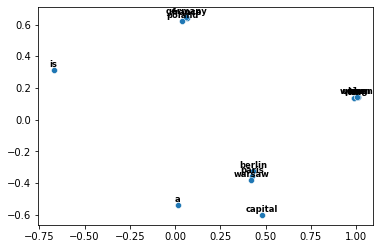

In [ ]:


import seaborn as sns
from sklearn import decomposition

w2v.word2idx[''] = 0
svd = decomposition.TruncatedSVD(n_components=2)
W2_dec = svd.fit_transform(embeddings)

x = W2_dec[:,0]
y = W2_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

for i in range(0,W2_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(w2v.word2idx)[i], horizontalalignment='center', size='small', color='black', weight='semibold');

Here, we will look into the learned property of the word2vec embedding. Warsaw is the capital of Poland and we now calculate the difference between embeddings of "warsaw" and "poland". After that, we add the difference to the embedding of "paris". We then rank the dot product of the computed embedding vs all the embeddings. The larger this value, the more similar two embeddings are. 

In [ ]:
emb1 = embeddings[w2v.word2idx["poland"]]
emb2 = embeddings[w2v.word2idx["warsaw"]]
emb3 = embeddings[w2v.word2idx["paris"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(w2v.idx2word[word_id], dists[word_id]))

poland: 0.683
paris: 0.485
germany: 0.275
france: 0.166
he: 0.031


## 1.2: Implementing Skip-Gram From Scratch 

A high level overview of the SkipGram model can be described as :    
<p align="center"><img src="https://miro.medium.com/max/720/1*SVs6xTpD7AYviP24UTOYUA.png" width="75%" align="center"></p>

The Skip-Gram model takes a single word as compared to CBOW model.

We will be implementing this model using the architecture described below :    

<p align="center"><img src="https://miro.medium.com/max/720/1*eHh1_t8Wms_hqDNBLuAnFg.png" width="75%" align="center"></p>

Here are the steps that needs to be followed for implementing SkipGram model :    
* Step-1: Create vocabulary
  * Split each words into tokens.
  * Assign a unique ID to each unique token.

* Step-2: Create SkipGram Embeddings
  * Create SkipGram embeddings by taking context as middle word.

* Step-3: Implement SkipGram Model
  * Implement SkipGram model as described in the architecture above. Output SkipGram embeddings for N past words and N future words.

**Hint:** Since we are using the cross entropy loss, there is no need to apply the softmax after the linear layer.

## 1.2.1: Fetching SkipGram embeddings 


In [ ]:
from word2vec import Word2Vec

w2v = Word2Vec()
tokens = w2v.tokenize(corpus)
w2v.create_vocabulary(tokens)
source, target = w2v.skipgram_embeddings(tokens)
print ('source', source)
print ('target', target)

source [[5], [5], [6], [6], [6], [0], [0], [0], [7], [7], [12], [12], [6], [6], [6], [0], [0], [0], [11], [11], [5], [5], [6], [6], [6], [0], [0], [0], [8], [8], [12], [12], [6], [6], [6], [0], [0], [0], [14], [14], [13], [13], [6], [6], [6], [10], [10], [10], [2], [2], [1], [1], [6], [6], [6], [4], [4], [4], [2], [2], [9], [9], [6], [6], [6], [3], [3], [3], [2], [2]]
target [[6], [0], [5], [0], [7], [5], [6], [7], [6], [0], [6], [0], [12], [0], [11], [12], [6], [11], [6], [0], [6], [0], [5], [0], [8], [5], [6], [8], [6], [0], [6], [0], [12], [0], [14], [12], [6], [14], [6], [0], [6], [10], [13], [10], [2], [13], [6], [2], [6], [10], [6], [4], [1], [4], [2], [1], [6], [2], [6], [4], [6], [3], [9], [3], [2], [9], [6], [2], [6], [3]]


## 1.2.2: Training SkipGram model 


In [ ]:

from word2vec import SkipGram_Model

N_EPOCHS = 300
model = SkipGram_Model(w2v.vocabulary_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()

for epoch in range(N_EPOCHS):
    total_loss = 0.0
    shuffled_i = list(range(0,len(target)))
    random.shuffle(shuffled_i)
    for i in shuffled_i:
        x = torch.from_numpy(np.asarray(source[i])).long().to(device)
        y = torch.from_numpy(np.asarray(target[i])).long().to(device)

        optimizer.zero_grad()
        outputs = model(x)
        print ('y', y.shape)
        loss = criterion(outputs, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
        
    if epoch % 20 == 0:    
      print("loss on epoch %i: %f" % (epoch, total_loss))

Streaming output truncated to the last 5000 lines.
output2 tensor([[ 2.8494, -4.0741, -2.6784, -2.8668, -2.9956, -3.6791,  2.7798, -4.0781,
         -4.0897, -3.8452, -2.8612, -4.0959, -3.5489, -4.2480, -4.2378]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y torch.Size([1])
output2 tensor([[-1.4691, -3.3640, -2.8483,  1.3626,  1.4692, -2.8004,  2.3720, -3.0144,
         -3.0516, -3.0923,  1.4013, -3.0440, -2.7669, -2.8816, -3.0726]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y torch.Size([1])
output2 tensor([[-1.2736, -3.1024, -2.0270, -0.9297, -0.9437, -3.2021,  2.5963, -3.4851,
         -3.5020, -2.9247,  2.5169, -3.5109, -3.1733, -2.9468, -3.5475]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y torch.Size([1])
output2 tensor([[-1.8660, -3.2427, -2.9122, -3.3470, -3.2815,  1.0622,  1.8524,  0.3648,
          0.3577, -3.4782, -3.2185,  0.3739,  1.0943, -3.4131,  0.3639]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
y torch.Size([1])
output2 tensor([[ 2.6690,

## 1.2.3: Visualizing SkipGram embeddings 

In [ ]:

# embedding from first model layer
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms

Here, we use truncated SVD to project the learned word2vec embedding to 2D space for visualization. 

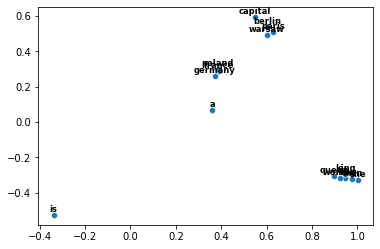

In [ ]:

from sklearn import decomposition

w2v.word2idx[''] = 0
svd = decomposition.TruncatedSVD(n_components=2)
W2_dec = svd.fit_transform(embeddings)

x = W2_dec[:,0]
y = W2_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

for i in range(0,W2_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(w2v.word2idx)[i], horizontalalignment='center', size='small', color='black', weight='semibold');

Here, we will look into the learned property of the word2vec embedding. Warsaw is the capital of Poland and we now calculate the difference between embeddings of "warsaw" and "poland". After that, we add the difference to the embedding of "paris". We then rank the dot product of the computed embedding vs all the embeddings. The larger this value, the more similar two embeddings are. 

In [ ]:
emb1 = embeddings[w2v.word2idx["poland"]]
emb2 = embeddings[w2v.word2idx["warsaw"]]
emb3 = embeddings[w2v.word2idx["paris"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(w2v.idx2word[word_id], dists[word_id]))

poland: 0.715
paris: 0.517
germany: 0.371
france: 0.364
king: 0.204


Ideally with large amount of data, we should have got france as the most nearest word. But depending on the implementation and amount of data, it can vary.

## Section 2: Classification with CNN

Convolutional layers are used to find patterns by sliding small kernel window over input. Instead of multiplying the filters on the small regions of the images, it slides through embedding vectors of few words as mentioned by window size. For looking at sequences of word embeddings, the window has to look at multiple word embeddings in a sequence. They will be rectangular with size window_size * embedding_size. For example, if window size is 3 then kernel will be 3*500. This essentially represents n-grams in the model. The kernel weights (filter) are multiplied to word embeddings in pairs and summed up to get output values. As the network is being learned, these kernel weights are also being learned.

We will be using convolutional network with pre-trained word2vec models for classification. We implement a convolutional neural network for text classification similar to the CNN-rand baseline described by [Kim (2014)](https://aclanthology.org/D14-1181.pdf). We use pre-trained word2vec models for feasibility of finding appropriate embeddings. The architecture of our model looks like :

<p align="center"><img src="https://cezannec.github.io/assets/cnn_text/complete_text_classification_CNN.png" width="75%" align="center"></p>

We will be using an Embedding layer loaded with a word2vec model, followed by a convolution layer, and a linear layer.

We will would be using the Clickbait and Web of science dataset for this task.

## 2.1: Implementing CNN classifier



### 2.1.1 : Pre-Processing Data 



In [ ]:

from gensim.utils import simple_preprocess

def preprocess(data):
  preprocessed_data = []
  for text in data:
    tokens = simple_preprocess(text, deacc=True)
    preprocessed_data.append(tokens)
  return preprocessed_data

preprocessed_x_train = preprocess(x_train)
preprocessed_x_train_wos = preprocess(x_train_wos)

preprocessed_x_test = preprocess(x_test)
preprocessed_x_test_wos = preprocess(x_test_wos)

In [1]:

# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

NameError: ignored

### 2.1.2 : Utility functions for training Word2Vec Model 

Run the below cells for making word2vec model, vectors and target.

In [ ]:
########

from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec

porter_stemmer = PorterStemmer()

size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(data, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    data.append(['pad'])
    w2v_model = Word2Vec(data, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
    return w2v_model

In [ ]:
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 43.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26527974 sha256=01e6db18d0be30c00ec4be70e5e0db93e6bc70a269accca3d02def84e741a2c8
  Stored in directory: /root/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim


In [ ]:

def make_word2vec_vector(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [ ]:

def make_target(label):
  return torch.tensor([label], dtype=torch.long, device=device)

## 2.2 : Classifying Clickbait Dataset using CNN


In [ ]:
# Train Word2vec model
w2vmodel = make_word2vec_model(preprocessed_x_train, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

Because CNN requires the input data to be of the same length. We use the embedding of the "pad" word as the padding vector. In more complex language model, there will be a dedicated '\<pad\>' token for padding.

In [ ]:
max_sen_len = max(map(len, preprocessed_x_train))
padding_idx = w2vmodel.wv.vocab['pad'].index

In [ ]:

from cnn import CNN

NUM_CLASSES = 2

model = CNN(w2vmodel, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
N_EPOCHS = 5

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    shuffled_i = list(range(0,len(y_train)))
    random.shuffle(shuffled_i)

    for index in range(len(shuffled_i)):
        model.zero_grad()
        bow_vec = make_word2vec_vector(preprocessed_x_train[index])
        outputs = model(bow_vec)
        y = make_target(y_train[index])

        loss = criterion(outputs, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()


    print("loss on epoch %i: %f" % (epoch, total_loss))

torch.FloatTensor(weights.vectors).size torch.Size([17099, 500])
loss on epoch 0: 7297.611781
loss on epoch 1: 7132.022539
loss on epoch 2: 7098.327129
loss on epoch 3: 7065.917294
loss on epoch 4: 7047.653477


In [ ]:

from sklearn.metrics import accuracy_score
cnn_predictions = []
original_lables_cnn = []
model.eval()

with torch.no_grad():
    for index in range(len(y_test)):
        bow_vec = make_word2vec_vector(preprocessed_x_test[index])
        probs = model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        cnn_predictions.append(predicted.cpu().numpy()[0])
        t = make_target(y_test[index]).cpu().numpy()[0]
        original_lables_cnn.append(make_target(y_test[index]).cpu().numpy()[0])

print("Test Accuracy on Clickbait Dataset using CNN : {:.3f}".format(accuracy_score(original_lables_cnn, cnn_predictions)))

Test Accuracy on Clickbait Dataset using CNN : 0.942


Run the below cell to save the predictions. You will be required to upload the predictions on gradescope for evaluation.

In [ ]:

preds = np.asarray(cnn_predictions)

with open('cnn_clickbait.pkl', 'wb') as fp:
    pickle.dump(preds, fp)

## 2.3 : Classifying Web of Science Dataset using CNN


In [ ]:

# Train Word2vec model
w2vmodel = make_word2vec_model(preprocessed_x_train_wos, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

In [ ]:

max_sen_len = max(map(len, preprocessed_x_train_wos))
padding_idx = w2vmodel.wv.vocab['pad'].index

In [ ]:

from cnn import CNN

NUM_CLASSES = 4

model = CNN(w2vmodel, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
N_EPOCHS = 20

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    shuffled_i = list(range(0,len(y_train_wos)))
    random.shuffle(shuffled_i)

    for index in range(len(shuffled_i)):
        model.zero_grad()
        bow_vec = make_word2vec_vector(preprocessed_x_train_wos[index])
        outputs = model(bow_vec)
        y = make_target(y_train_wos[index])

        loss = criterion(outputs, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()


    if epoch % 5 == 0:    
      print("loss on epoch %i: %f" % (epoch, total_loss))

torch.FloatTensor(weights.vectors).size torch.Size([17643, 500])
loss on epoch 0: 1971.492377
loss on epoch 5: 1602.236836
loss on epoch 10: 1518.951085
loss on epoch 15: 1465.984390


In [ ]:

from sklearn.metrics import accuracy_score
cnn_predictions = []
original_lables_cnn = []
model.eval()

with torch.no_grad():
    for index in range(len(y_test_wos)):
        bow_vec = make_word2vec_vector(preprocessed_x_test_wos[index])
        probs = model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        cnn_predictions.append(predicted.cpu().numpy()[0])
        t = make_target(y_test_wos[index]).cpu().numpy()[0]
        original_lables_cnn.append(make_target(y_test_wos[index]).cpu().numpy()[0])

print("Test Accuracy on WoS Dataset using CNN : {:.3f}".format(accuracy_score(original_lables_cnn, cnn_predictions)))

Test Accuracy on WoS Dataset using CNN : 0.598


In [ ]:

preds = np.asarray(cnn_predictions)

with open('cnn_wos.pkl', 'wb') as fp:
    pickle.dump(preds, fp)

## Section 3: Classification with RNN 


We will be using recurrent neural networks with pre-trained word2vec models for classification. We use pre-trained word2vec models for feasibility of finding appropriate embeddings. The architecture of our model looks like :

<p align="center"><img src="https://www.tensorflow.org/static/text/tutorials/images/bidirectional.png" width="75%" align="center"></p>

We will be using an Embedding layer loaded, followed by a RNN layer, and a linear layer.

We will would be using the Clickbait and Web of science dataset for this task.

## 3.1: Implementing RNN classifier


### 3.1.1 : Pre-Processing Data 


In [ ]:

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
  for dataset in datasets:
    for text in dataset:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([x_train]), min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

vocab_wos = build_vocab_from_iterator(build_vocabulary([x_train_wos]), min_freq=1, specials=["<UNK>"])
vocab_wos.set_default_index(vocab["<UNK>"])

## 3.2 : Classifying Clickbait Dataset using RNN 



In [ ]:

from torch.utils.data import DataLoader

max_words = max(map(len, x_train))

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] ## Tokenize and map tokens to indexes
    X_len = [len(text) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    return torch.tensor(X, dtype=torch.int32), torch.tensor(X_len), torch.tensor(Y)

In [ ]:

train_dataset = list(map(lambda y, x: (y, x), y_train, x_train))
test_dataset = list(map(lambda y, x: (y, x), y_test, x_test))

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [ ]:
from rnn import RNN
from tqdm import tqdm

NUM_CLASSES = 2

model = RNN(vocab, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
N_EPOCHS = 5

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    for X, X_len, Y in tqdm(train_loader):
      X = X.to(device)
      Y = Y.to(device)
      outputs = model(X, X_len)
      loss = criterion(outputs, Y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print("loss on epoch %i: %f" % (epoch, total_loss))

100%|██████████| 19/19 [00:01<00:00,  9.72it/s]


loss on epoch 0: 7.933816


100%|██████████| 19/19 [00:00<00:00, 22.75it/s]


loss on epoch 1: 2.840996


100%|██████████| 19/19 [00:00<00:00, 28.70it/s]


loss on epoch 2: 1.255670


100%|██████████| 19/19 [00:00<00:00, 34.06it/s]


loss on epoch 3: 0.587396


100%|██████████| 19/19 [00:00<00:00, 33.56it/s]

loss on epoch 4: 0.293105


In [ ]:

from sklearn.metrics import accuracy_score

with torch.no_grad():
  Y_truth, Y_preds = [],[]
  for X, X_len, Y in test_loader:
    X = X.to(device)
    outputs = model(X, X_len)

    Y_truth.append(Y)
    Y_preds.append(outputs)

  Y_truth = torch.cat(Y_truth)
  Y_preds = torch.cat(Y_preds)

print("Test Accuracy on Clickbait Dataset using RNN  : {:.3f}".format(accuracy_score(Y_truth.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy())))

Test Accuracy on Clickbait Dataset using RNN  : 0.948


In [ ]:

preds = F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

with open('rnn_clickbait.pkl', 'wb') as fp:
    pickle.dump(preds, fp)

## 3.3 : Classifying Web of Science Dataset using RNN 


In [ ]:


max_words = max(map(len, x_train_wos))

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab_wos(tokenizer(text)) for text in X] ## Tokenize and map tokens to indexes
    X_len = [len(text) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 
    return torch.tensor(X, dtype=torch.int32), torch.tensor(X_len), torch.tensor(Y)

In [ ]:

train_dataset = list(map(lambda y, x: (y, x), y_train_wos, x_train_wos))
test_dataset = list(map(lambda y, x: (y, x), y_test_wos, x_test_wos))

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, collate_fn=vectorize_batch)

In [ ]:
from rnn import RNN
from tqdm import tqdm

NUM_CLASSES = 4

model = RNN(vocab_wos, num_classes=NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
N_EPOCHS = 20

model.train()
for epoch in range(N_EPOCHS):
    total_loss = 0.0
    for X, X_len, Y in tqdm(train_loader):
      X = X.to(device)
      Y = Y.to(device)
      outputs = model(X, X_len)
      loss = criterion(outputs, Y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print("loss on epoch %i: %f" % (epoch, total_loss))

100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


loss on epoch 0: 17.426557


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


loss on epoch 1: 16.369169


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


loss on epoch 2: 15.574879


100%|██████████| 13/13 [00:01<00:00,  7.28it/s]


loss on epoch 3: 14.727391


100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


loss on epoch 4: 13.975107


100%|██████████| 13/13 [00:01<00:00,  7.64it/s]


loss on epoch 5: 13.247627


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


loss on epoch 6: 12.567268


100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


loss on epoch 7: 11.898193


100%|██████████| 13/13 [00:01<00:00,  8.21it/s]


loss on epoch 8: 11.056605


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


loss on epoch 9: 10.089526


100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


loss on epoch 10: 9.197750


100%|██████████| 13/13 [00:01<00:00,  7.71it/s]


loss on epoch 11: 8.457468


100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


loss on epoch 12: 7.672253


100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


loss on epoch 13: 6.900614


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


loss on epoch 14: 5.936187


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


loss on epoch 15: 5.130258


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


loss on epoch 16: 4.428470


100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


loss on epoch 17: 3.818452


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


loss on epoch 18: 3.177522


100%|██████████| 13/13 [00:01<00:00,  7.69it/s]

loss on epoch 19: 2.727766


In [ ]:

from sklearn.metrics import accuracy_score

with torch.no_grad():
  Y_truth, Y_preds = [],[]
  for X, X_len, Y in test_loader:
    X = X.to(device)
    outputs = model(X, X_len)

    Y_truth.append(Y)
    Y_preds.append(outputs)

  Y_truth = torch.cat(Y_truth)
  Y_preds = torch.cat(Y_preds)

print("Test Accuracy on WoS Dataset using RNN  : {:.3f}".format(accuracy_score(Y_truth.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy())))

Test Accuracy on WoS Dataset using RNN  : 0.448


In [ ]:

preds = F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

with open('rnn_wos.pkl', 'wb') as fp:
    pickle.dump(preds, fp)

**NOTE** : RNN alone is not able to perform good on the WoS dataset and that can be attributed to the very limited data with large vocabulary and lack of embedding structure.